In [ ]:
# 필요한 모듈 임포트
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [ ]:
# 기상관측 자료 로딩
obs_list = ############## 여기에 ################

obs_list

In [ ]:
# 데이터 컬럼 및 타입 확인
obs_list.############## 여기에 ################


In [ ]:
# 컬럼명 변경
obs_list.columns = ['지점','지점명','일시','최고기온','최고풍속']

In [ ]:
# 데이터 타입 변경
obs_list['지점'] = obs_list['지점'].astype(object)
obs_list['지점명'] = obs_list['지점명'].astype(object)
obs_list['최고기온'] = obs_list['최고기온'].astype(float)
obs_list['최고풍속'] = obs_list['최고풍속'].astype(float)
obs_list['일시'] = pd.to_datetime(obs_list['일시'], format='%Y-%m-%d')
obs_list.info()

In [ ]:
# 화재발생 시군구와 매칭하기 위하여 기상관측지점명 전체 집합(Set) 생성
obs_branch_set = set(obs_list['지점명'])
print(len(obs_branch_set))
print(obs_branch_set)

In [ ]:
# 소방청 국가화재정보 시도단위 화재발생현황목록 로딩
fire_list = pd.read_csv('/content/화재발생정보2017.csv', encoding='euc-kr')
fire_list

In [ ]:
fire_list.info()

In [ ]:
# 학습에 필요없는 컬럼 제거
fire_list.drop(['연번', '사망', '부상', '인명피해(명)소계', '시도', '읍면동', '장소대분류', '부동산', '동산', '장소대분류', '장소중분류', '장소소분류'],axis=1,inplace=True)
fire_list

In [ ]:
# 기상관측자료의 관측일시(연월일만 존재)와 매칭하기 위해서 화재발생년월일 중 시간 정보 삭제
def date_convert(x):
  split_x = x.split()
  return split_x[0]

fire_list['화재발생년월일']=fire_list['화재발생년월일'].apply(date_convert)
fire_list

In [ ]:
# 데이터 타입 확인
fire_list.info()

In [ ]:
# 데이터 타입 변환
fire_list['화재발생년월일'] = pd.to_datetime(fire_list['화재발생년월일'], format='%Y-%m-%d')
fire_list.info()

In [ ]:
# 기상관측자료의 지점명과 매칭시키기 위해 (시군구 등 행정단위가 없음) 화재발생자료의 시군구 컬럼에서 행정단위 제거 및 기상관측지점명과 매칭
def trunk_region(x) :
  for region in obs_branch_set:  
    if region in x:      
      return region
  return np.NaN

fire_list['시군구'] = fire_list['시군구'].apply(trunk_region)
fire_list

In [ ]:
# 매칭 안된 시군구 갯수 확인
fire_list.isna().sum()

In [ ]:
# 매칭 안된 화재발생 자료 삭제
fire_list.dropna(axis=0, inplace=True)
fire_list.isna().sum()

In [ ]:
fire_list

In [ ]:
# 매칭된 시군구 및 갯수 확인
print(fire_list['시군구'].unique())
print(fire_list['시군구'].nunique())

In [ ]:
# 기상관측자료와 화재발생자료를 시군구 및 화재발생년월일을 기준으로 조인
fire_obs_list = pd.merge(left = fire_list , right = obs_list, left_on = ['시군구','화재발생년월일'], right_on = ['지점명','일시'], how = "inner")
fire_obs_list

In [ ]:
# 결측값 갯수 확인
fire_obs_list.isna().sum()

In [ ]:
# 결측데이터 삭제
fire_obs_list.dropna(axis=0,inplace=True)

In [ ]:
fire_obs_list.info()

In [ ]:
# 중복 컬럼 삭제
fire_obs_list.drop(['지점','지점명','일시'],axis=1, inplace=True)
fire_obs_list

In [ ]:
# 특징과 정답(label) 추출
x_data = fire_obs_list[['최고기온','최고풍속']]
y_data = fire_obs_list['재산피해소계']

In [ ]:
x_data

In [ ]:
y_data

In [ ]:
# 학습집합과 테스트집합 분리 (30%)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = # 여기에 #

In [ ]:
# 분리된 갯수 확인
print(x_train.shape); print(x_test.shape); print(y_train.shape); print(y_test.shape)

In [ ]:
# 데이터 스케일 조정

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train_scaled

In [ ]:
x_test_scaled

In [ ]:
# 모델 정의를 위한 모듈 임포트
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# 텐서플로우 학습데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train.values))
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(1)

In [ ]:
# 화재 발생 건수 예측 모델 정의 (지역별 최고 기온, 최대 풍속을 입력 특징으로 하고 화재 발생 피해액 예측)

model = Sequential()

############## 여기에 ################

model.summary()

In [ ]:
# 모델 학습
model.compile(loss='MeanAbsoluteError', optimizer='Adam')
hist = ############## 여기에 ################


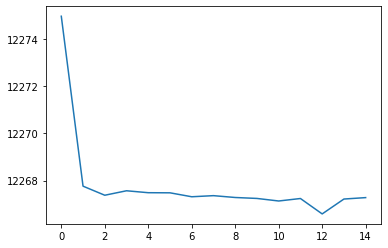

In [ ]:
# 학습과정 가시화
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.show()


In [ ]:
# 모델 평가
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test.values))
test_dataset = test_dataset.shuffle(len(test_dataset)).batch(1)
results = ############## 여기에 ################
print(f"test loss: {results}")

In [ ]:
# 추론
real_data = scaler.transform([[30.4,25.0]])
y_pred = ############## 여기에 ################
print(y_pred)